<a href="https://colab.research.google.com/github/himanshudas13/Land-Use-Land-Cover/blob/master/Prediction/lulc452_644.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

numberninja13_augmented2_path = kagglehub.dataset_download('numberninja13/augmented2')

print('Data source import complete.')


In [ ]:
import cv2

import os

import numpy as np

import keras

from keras import layers

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt

from keras.models import load_model

import pandas as pd


In [ ]:
import os
from PIL import Image

# Set the root directory containing the images (including subdirectories)
root_directory = '/kaggle/input/augmented2/Augmented-Images'

# Initialize a set to store unique shapes
unique_shapes = set()

# Loop through the directory and its subdirectories using os.walk()
for subdir, dirs, files in os.walk(root_directory):
    for filename in files:
        file_path = os.path.join(subdir, filename)

        try:
            # Open the image using PIL
            with Image.open(file_path) as img:
                image_shape = img.size + (len(img.getbands()),)  # Get (width, height) and add number of channels

            # Add the image shape to the set (only unique shapes will be stored)
            unique_shapes.add(image_shape)

        except Exception as e:
            print(f"Could not open file {filename}: {e}")

# Print all unique image sizes
print("Unique image shapes:")
for shape in unique_shapes:
    print(shape)


Unique image shapes:
(452, 644, 4)
(644, 452, 4)


In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split


def process_images_in_folders(base_folder='images', output_dir='output', target_size=(256, 256), train_ratio=0.8):
    sequence_dirs = []
    temp_sequences = []
    sequence_counter = 1  # To keep track of sequence numbers globally

    # Ensure the output directory exists; create it if it doesn't
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Clear the existing output directory if it exists
    clear_directory(output_dir)

    # Create fresh output directories for train and val
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Loop over each sub-folder in the 'images' directory
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)

        if os.path.isdir(folder_path):
            images = sorted(os.listdir(folder_path))

            if len(images) >= 30:
                # Create 6 sequences of 5 images each
                sequences = [[], [], [], [], [], []]

                for i in range(30):
                    image_path = os.path.join(folder_path, images[i])
                    img = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
                    # img = img.resize(target_size)
                    img_array = np.array(img) / 255.0  # Normalize image


                    # Add the image to the appropriate sequence
                    sequences[i // 5].append((img, images[i]))  # Keep image and original filename

                # Process each sequence and append directory names for splitting
                for seq in sequences:
                    sequence_folder = f'seq{sequence_counter}'  # Use seq1, seq2, etc.
                    sequence_dirs.append(sequence_folder)
                    temp_sequences.append(seq)

                    # Save sequences directly as image files in the train directory
                    save_sequence_as_images(seq, os.path.join(train_dir, f'seq{sequence_counter}'))
                    sequence_counter += 1

    # Split sequences between training and validation
    train_sequences, val_sequences = train_test_split(temp_sequences, train_size=train_ratio, random_state=42)

    # Save validation sequences as images in the val directory
    for idx, seq in enumerate(val_sequences):
        save_sequence_as_images(seq, os.path.join(val_dir, f'seq{idx+1}'))

    print(f'Training data saved to: {train_dir}')
    print(f'Validation data saved to: {val_dir}')


def save_sequence_as_images(sequence, seq_folder):
    """
    Save each image in the sequence to the specified folder.
    """
    os.makedirs(seq_folder, exist_ok=True)

    for idx, (img, original_filename) in enumerate(sequence):
        img_save_path = os.path.join(seq_folder, f'img{idx+1}_{original_filename}')
        img.save(img_save_path)
        print(f'Image saved to: {img_save_path}')


def clear_directory(directory):
    """Clears the content of a directory by removing it."""
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory, exist_ok=True)


# Call the function with your dataset path and output directory
process_images_in_folders('/kaggle/input/augmented2/Augmented-Images', output_dir='/kaggle/working/imgset')


Image saved to: /kaggle/working/imgset/train/seq1/img1_1990.png
Image saved to: /kaggle/working/imgset/train/seq1/img2_1991.png
Image saved to: /kaggle/working/imgset/train/seq1/img3_1992.png
Image saved to: /kaggle/working/imgset/train/seq1/img4_1993.png
Image saved to: /kaggle/working/imgset/train/seq1/img5_1994.png
Image saved to: /kaggle/working/imgset/train/seq2/img1_1995.png
Image saved to: /kaggle/working/imgset/train/seq2/img2_1996.png
Image saved to: /kaggle/working/imgset/train/seq2/img3_1997.png
Image saved to: /kaggle/working/imgset/train/seq2/img4_1998.png
Image saved to: /kaggle/working/imgset/train/seq2/img5_1999.png
Image saved to: /kaggle/working/imgset/train/seq3/img1_2000.png
Image saved to: /kaggle/working/imgset/train/seq3/img2_2001.png
Image saved to: /kaggle/working/imgset/train/seq3/img3_2002.png
Image saved to: /kaggle/working/imgset/train/seq3/img4_2003.png
Image saved to: /kaggle/working/imgset/train/seq3/img5_2004.png
Image saved to: /kaggle/working/imgset/t

In [ ]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder, seq_length=5, img_size=(256, 256)):
    images = []
    labels = []
    for seq in os.listdir(folder):
        seq_path = os.path.join(folder, seq)
        # Get all image paths for the sequence
        img_paths = sorted([os.path.join(seq_path, img) for img in os.listdir(seq_path)])

        # Make sure each sequence has exactly `seq_length` images
        if len(img_paths) == seq_length:
            seq_images = [cv2.imread(img_path) for img_path in img_paths]
            seq_images = [cv2.resize(img, img_size) for img in seq_images]
            seq_images = np.array(seq_images) / 255.0  # Normalize
            images.append(seq_images[:4])  # First 4 images for input
            labels.append(seq_images[4])  # 5th image as output
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder('/kaggle/working/imgset/train')
val_images, val_labels = load_images_from_folder('/kaggle/working/imgset/val')


In [ ]:
print(f"Shape of train_images: {train_images.shape}")
print(f"Shape of val_images: {val_images.shape}")
print(f"Shape of train_labels: {train_labels.shape}")
print(f"Shape of val_labels: {val_labels.shape}")

Shape of train_images: (48, 4, 256, 256, 3)
Shape of val_images: (10, 4, 256, 256, 3)
Shape of train_labels: (48, 256, 256, 3)
Shape of val_labels: (10, 256, 256, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, BatchNormalization, Dropout

def build_model(input_shape=(4, 128, 128, 3)):
    model = Sequential()

    # ConvLSTM block 1
    model.add(ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # ConvLSTM block 2 (fewer filters)
    model.add(ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # ConvLSTM block 3 (fewer filters)
    model.add(ConvLSTM2D(128, (3, 3), padding='same', return_sequences=False))  # Fewer filters and no return_sequences
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output Conv2D layer to generate the predicted image
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    model.compile(optimizer='adam', loss='mse')

    return model

model = build_model(input_shape=(4, 128, 128, 3))
model.summary()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)


In [ ]:
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=200,  # Increase the number of epochs
    batch_size=8,
    #callbacks=[early_stopping]  # Add the EarlyStopping callback
)


In [ ]:

model.save('/kaggle/working/my_rnn_model3.h5')  # Save in HDF5 format


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Choose a random sequence from the validation set
import random
idx = random.randint(0, len(val_images)-1)

# Get input and expected output
input_seq = np.expand_dims(val_images[idx], axis=0)  # Shape (1, 4, 64, 64, 3)
expected_output = np.expand_dims(val_labels[idx], axis=0)  # Shape (1, 64, 64, 3)

# Predict the next image
predicted_output = model.predict(input_seq)

# Display the results
plt.subplot(1, 3, 1)
plt.title("Input Sequence")
plt.imshow(input_seq[0][-1])  # Display the last image of the input sequence

plt.subplot(1, 3, 2)
plt.title("Expected Output")
plt.imshow(expected_output[0])

plt.subplot(1, 3, 3)
plt.title("Predicted Output")
plt.imshow(predicted_output[0])

plt.show()


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Choose a random sequence from the validation set
idx = random.randint(0, len(val_images) - 1)

# Get input and expected output
input_seq = np.expand_dims(val_images[idx], axis=0)  # Shape (1, 4, 64, 64, 3)
expected_output = np.expand_dims(val_labels[idx], axis=0)  # Shape (1, 64, 64, 3)

# Predict the next image
predicted_output = model.predict(input_seq)

# Plot the input sequence (separate figures for each input image)
plt.figure(figsize=(10, 5))
for i in range(input_seq.shape[1]):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Input Image {i+1}")
    plt.imshow(input_seq[0][i])
    plt.axis('off')  # Hide axis for a cleaner display

plt.tight_layout()
plt.show()

# Plot expected and predicted output side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Expected Output")
plt.imshow(expected_output[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Output")
plt.imshow(predicted_output[0])
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, SeparableConv2D, BatchNormalization, Dropout

def build_model(input_shape=(4, 256, 256, 3)):
    model = Sequential()

    # ConvLSTM block 1 (fewer filters and smaller kernel)
    model.add(ConvLSTM2D(16, (2, 2), padding='same', return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # ConvLSTM block 2 (fewer filters)
    model.add(ConvLSTM2D(32, (2, 2), padding='same', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # ConvLSTM block 3 (fewer filters, no return_sequences)
    model.add(ConvLSTM2D(64, (2, 2), padding='same', return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output SeparableConv2D layer instead of Conv2D to reduce parameters
    model.add(SeparableConv2D(3, (3, 3), activation='sigmoid', padding='same'))

    model.compile(optimizer='adam', loss='mse')

    return model

# Build model for input shape (4, 256, 256, 3)
model = build_model(input_shape=(4, 256, 256, 3))
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 4, 256, 256,    │         4,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 256, 256,    │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 256, 256,    │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 4, 256, 256,    │        24,704 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 256, 256,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 256, 256,    │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, 256, 256, 64)   │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 256, 256, 3)    │           771 │
│ (SeparableConv2D)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,411 (505.51 KB)

 Trainable params: 129,187 (504.64 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=200,  # Increase the number of epochs
    batch_size=8,
    #callbacks=[early_stopping]  # Add the EarlyStopping callback
)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1481 - val_loss: 0.1532
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.1268 - val_loss: 0.1491
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.1206 - val_loss: 0.1462
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.1150 - val_loss: 0.1436
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.1088 - val_loss: 0.1381
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.1014 - val_loss: 0.1304
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0917 - val_loss: 0.1211
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0814 - val_loss: 0.1093
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0705 - val_loss: 0.0960
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0601 - val_loss: 0.0823
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0504 - val_loss: 0.0701
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0421 - val_loss: 0.0602
Epoch 13/200

In [ ]:
model.save('/kaggle/working/my_rnn_model2562.h5')

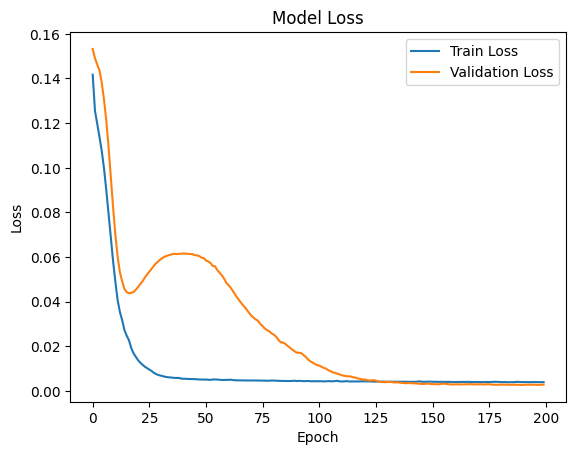

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


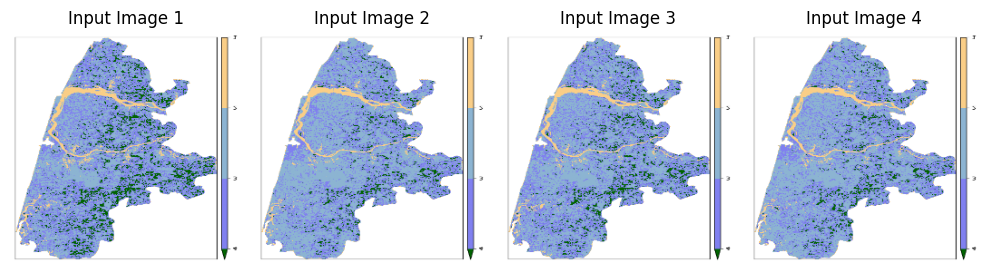

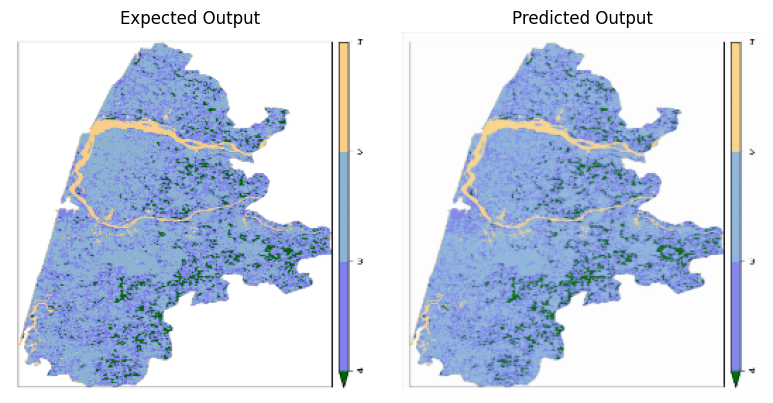

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Choose a random sequence from the validation set
idx = random.randint(0, len(val_images) - 1)

# Get input and expected output
input_seq = np.expand_dims(val_images[idx], axis=0)  # Shape (1, 4, 64, 64, 3)
expected_output = np.expand_dims(val_labels[idx], axis=0)  # Shape (1, 64, 64, 3)

# Predict the next image
predicted_output = model.predict(input_seq)

# Plot the input sequence (separate figures for each input image)
plt.figure(figsize=(10, 5))
for i in range(input_seq.shape[1]):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Input Image {i+1}")
    plt.imshow(input_seq[0][i])
    plt.axis('off')  # Hide axis for a cleaner display

plt.tight_layout()
plt.show()

# Plot expected and predicted output side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Expected Output")
plt.imshow(expected_output[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Output")
plt.imshow(predicted_output[0])
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Function to convert BGR to RGB
def bgr_to_rgb(image):
    return image[..., ::-1]  # Reverses the last channel to switch BGR to RGB

# Choose a random sequence from the validation set
idx = random.randint(0, len(val_images) - 1)

# Get input and expected output
input_seq = np.expand_dims(val_images[idx], axis=0)  # Shape (1, 4, 64, 64, 3)
expected_output = np.expand_dims(val_labels[idx], axis=0)  # Shape (1, 64, 64, 3)

# Predict the next image
predicted_output = model.predict(input_seq)

# Plot the input sequence (separate figures for each input image)
plt.figure(figsize=(10, 5))
for i in range(input_seq.shape[1]):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Input Image {i+1}")
    # Convert from BGR to RGB before displaying
    plt.imshow(bgr_to_rgb(input_seq[0][i]))
    plt.axis('off')  # Hide axis for a cleaner display

plt.tight_layout()
plt.show()

# Plot expected and predicted output side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Expected Output")
# Convert from BGR to RGB before displaying
plt.imshow(bgr_to_rgb(expected_output[0]))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Output")
# Convert from BGR to RGB before displaying
plt.imshow(bgr_to_rgb(predicted_output[0]))
plt.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'val_images' is not defined